In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
from sklearn.svm import  SVC
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from skimage.feature import hog
import cv2
import imutils
import joblib
import umap
from sklearn.decomposition import PCA





In [ ]:
def show_images(images,figure,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure(figure)
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)

def plot_embeddings(emb_train, train_labels, emb_test):
    reducer = umap.UMAP()
    twodim_train = reducer.fit_transform(emb_train)
    twodim_test = reducer.transform(emb_test)
    
    _, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.scatter(twodim_test[:,0], twodim_test[:,1])
    
    for i in range(500):
        pos_x, pos_y = twodim_train[i,0], twodim_train[i,1]
        ax.text(pos_x, pos_y, f'{train_labels[i]}')

Error: Session cannot generate requests

In [ ]:
img = cv2.imread('../datasets/digits/2.jpg')
vis_img = img.copy()
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(5,5),0)
_,thresh =  cv2.threshold(blur, 150, 255,cv2.THRESH_BINARY_INV)
print(thresh.shape)

plt.imshow(thresh)

Error: Session cannot generate requests

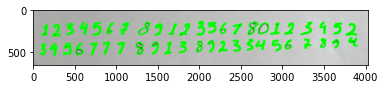

In [ ]:
# find contours in the thresholded image, then initialize the
# digit contours lists
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
digit_bb = []
# loop over the digit area candidates
for c in cnts:
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)
	# if the contour is sufficiently large, it must be a digit
	if w >= 50 and (h >= 100 and h <= 800):
		digit_bb.append([x, y, w, h])
		cv2.drawContours(vis_img, [c], -1, (0, 255, 0), 15)

plt.imshow(vis_img)

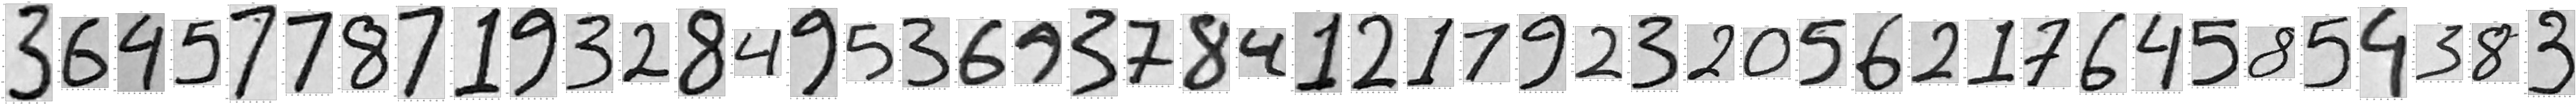

In [ ]:
digits = []
for bb in digit_bb:
    x,y,w,h = bb
    digits.append(gray[y:y+h,x:x+w])
 
show_images(digits,0) #5 9 4 3 4 6 2

In [ ]:
actual= np.array([3,6,4,5,7,7,8,7,1,9,3,2,8,4,9,5,3,6,9,3,7,8,4,1,2,1,7,9,2,3,2,0,5,6,2,1,7,6,4,5,8,5,4,3,8,3])
len(actual)

46

In [ ]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
y = y.astype(int)

In [ ]:
X_sampled, _, y_sampled, _ = train_test_split(X,y,test_size=0.002, random_state=30, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_sampled,y_sampled,test_size=0.2, random_state=30)

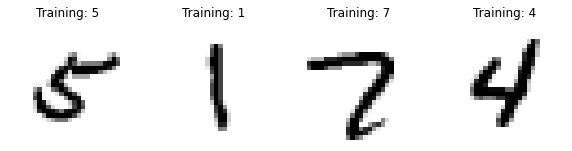

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, X_train, y_train):
    ax.set_axis_off()
    ax.imshow(image.reshape(28,28), cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

In [ ]:
X_train.shape


Error: Session cannot generate requests

# Features Extraction

In [ ]:
PEXILS_PER_CELL = (12,12)

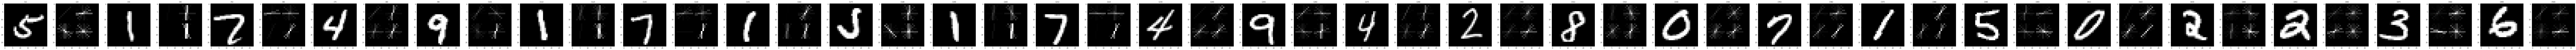

In [ ]:
NUMBER_OF_IMAGES = 25
hog_image = [hog(img.reshape(28,28), orientations=9, pixels_per_cell=PEXILS_PER_CELL,cells_per_block=(2, 2), visualize=True, multichannel=False)[1] for img in X_train[:NUMBER_OF_IMAGES]]
show_images(np.array([*zip([img.reshape(28,28) for img in X_train[:NUMBER_OF_IMAGES]],hog_image)]).reshape(50,28,28),0)

In [ ]:
get_hog =  lambda imgs: np.array([ hog(img.reshape(28,28), orientations=9, pixels_per_cell=PEXILS_PER_CELL,cells_per_block=(2, 2), visualize=False, multichannel=False) for img in imgs])

In [ ]:
# img = cv2.threshold(X_train[5] , 20, 255,cv2.THRESH_BINARY_INV)[1].reshape(28,28)
def get_bw_transition_areas(img):
    binary_img = cv2.threshold(img , 20, 255,cv2.THRESH_BINARY_INV)[1].reshape(28,28)
    digit_indecies = np.where(binary_img == 0)
    digit_indecies = np.array([*zip(digit_indecies[0],digit_indecies[1])])
    h_area = np.sum(binary_img[digit_indecies[:,0],digit_indecies[:,1] - 1] == 255)
    v_area = np.sum(binary_img[digit_indecies[:,0] -1,digit_indecies[:,1]] == 255)
    # right_col = digit_indecies[:,1] + 1
    # right_row = digit_indecies[:,0]
    # exceding_col_mask = right_col >= img.shape[1] 
    # if np.sum(exceding_col_mask) >= 1:
    #     right_col = right_col[~exceding_col_mask]
    #     right_row = right_row[~exceding_col_mask]
    # right_area = np.sum(img[right_row,right_col] == 255)
    img_area = binary_img.shape[0] * binary_img.shape[1]
    return h_area /  img_area , v_area / img_area

get_bw_transition_areas(X_train[9])

(0.025510204081632654, 0.007653061224489796)

In [ ]:
a = np.array([[ 1.,  1.,  1.,  1.,  1.],
              [ 1.,  1.,  1.,  1.,  1.],
              [ 1.,  1.,  1.,  1.,  1.]])

np.pad(a, [(0,1)], mode='constant')

array([[1., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [ ]:
GAMMA = 1 * 10^-3

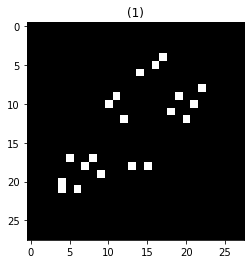

In [ ]:
def curvature_transform(img,shape=(28,28)):
    curvature = lambda dX,dY,d2X,d2Y :np.sqrt(np.power(d2Y*dX-d2X*dY,2)/np.power(d2X+d2Y,3))
    pad_col = lambda a:  np.pad(a, [(0,1)], mode='constant')[:-1,:]
    pad_row = lambda a:  np.pad(a, [(0,1)], mode='constant')[:,:-1]

    dX = np.abs(pad_row(np.diff(img.reshape(*shape),axis=0)))
    d2X = np.abs(pad_row(np.diff(dX,axis=0)))
    dY = np.abs(pad_col(np.diff(img.reshape(*shape),axis=1)))
    d2Y = np.abs(pad_col(np.diff(dY,axis=1)))

    ROI_mask = (d2X != 0)&(d2Y != 0)
    K = np.zeros_like(dX)
    K[ROI_mask] = curvature(dX[ROI_mask],dY[ROI_mask],d2X[ROI_mask],d2Y[ROI_mask])
    sc = StandardScaler()
    K = sc.fit_transform(K)

    return K

show_images([curvature_transform(X_train[20])>3],0)

In [ ]:
result = {i:[] for i in range(10)}
for i,img in enumerate(X_train[:50000]):
    K = curvature_transform(img) 
    result[y_train[i]].append(np.sum(K>2))

result

{0: [36,
  33,
  29,
  34,
  29,
  34,
  36,
  35,
  33,
  32,
  28,
  33,
  25,
  35,
  30,
  15,
  24,
  30,
  32,
  36,
  40,
  44,
  33,
  36,
  31,
  33,
  36,
  35,
  34,
  27,
  31,
  36,
  19,
  42,
  36,
  36,
  39,
  32,
  40,
  36,
  37,
  33,
  31,
  28,
  32,
  32,
  34,
  35,
  26,
  27,
  41,
  34,
  34,
  29,
  27,
  34,
  38,
  29,
  35,
  22,
  35,
  26,
  32,
  25,
  23,
  39,
  35,
  39,
  31,
  36,
  34,
  36,
  31,
  34,
  30,
  36,
  37,
  38,
  30,
  28,
  39,
  23,
  27,
  33,
  34,
  23,
  27,
  37,
  22,
  27,
  33,
  36,
  29,
  34,
  15,
  28,
  31,
  33,
  32,
  41,
  29,
  33,
  33,
  31,
  35,
  29,
  34,
  34,
  37,
  35,
  37,
  29,
  26,
  34,
  32,
  26,
  28,
  35,
  32,
  29,
  37,
  31,
  28,
  31,
  23,
  39,
  40,
  38,
  28,
  33,
  27,
  32,
  28,
  30,
  32,
  37,
  34,
  36,
  30,
  31,
  34,
  24,
  28,
  27,
  31,
  36,
  35,
  29,
  26,
  32,
  33,
  32,
  31,
  32,
  25,
  31,
  32,
  36,
  29,
  35,
  31,
  33,
  39,
  39,
  38,
  21,
 

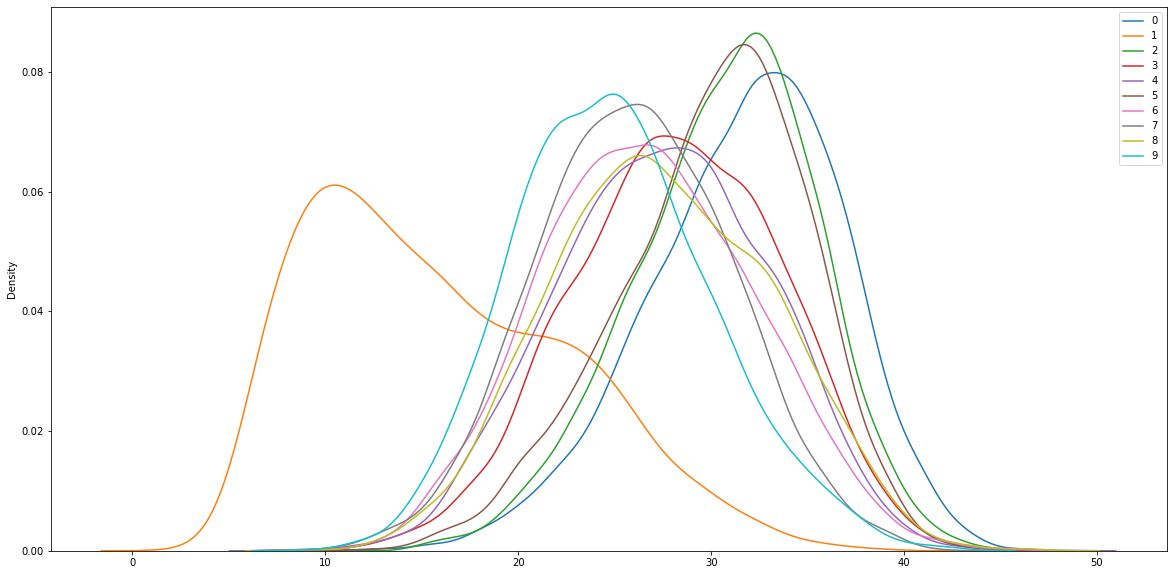

In [ ]:
plt.figure(figsize=(20,10))
_=[sns.kdeplot(result[i]) for i in range(10)]
plt.legend([i for i in range(10)])

In [ ]:
preprocess = lambda imgs: np.array([ np.hstack([hog(img.reshape(28,28), orientations=9, pixels_per_cell=PEXILS_PER_CELL,cells_per_block=(2, 2), visualize=False, multichannel=False),get_bw_transition_areas(img)]) for img in imgs])
preprocess_reshaped = lambda imgs: np.array([ np.hstack([hog(img, orientations=9, pixels_per_cell=PEXILS_PER_CELL,cells_per_block=(2, 2), visualize=False, multichannel=False),get_bw_transition_areas(img)]) for img in imgs])

In [ ]:
X_train = preprocess(X_train)
sc = StandardScaler()
#X_train = sc.fit_transform(X_train)

In [ ]:
X_test = preprocess(X_test)
#X_test = sc.transform(X_test)

In [ ]:
X_train[0]

array([0.00289344, 0.00828808, 0.13650345, 0.00801496, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01610655,
       0.14316759, 0.24455762, 0.27397595, 0.27397595, 0.03448542,
       0.        , 0.04124464, 0.12517635, 0.27202989, 0.08564303,
       0.05157368, 0.        , 0.15033443, 0.27397595, 0.27397595,
       0.16683038, 0.26290471, 0.15768413, 0.08323888, 0.26310598,
       0.27309469, 0.27397595, 0.13211097, 0.27397595, 0.18226069,
       0.04366923, 0.03061224, 0.03826531])

In [ ]:
pca = PCA(0.95)
pca.fit(X_train)
X_train_d = pca.transform(X_train)
X_test_d = pca.transform(X_test)

In [ ]:
X_train.shape

(55888, 38)

In [ ]:
X_train_d.shape

(55888, 28)

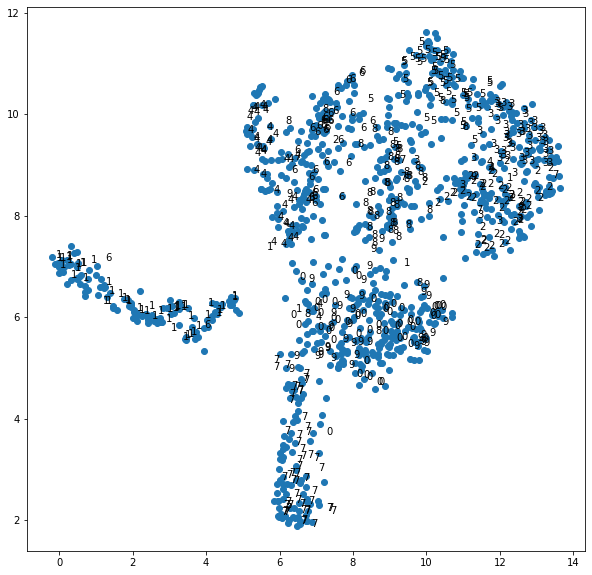

In [ ]:
plot_embeddings(X_train[:2000],y_train,X_test[:1000])

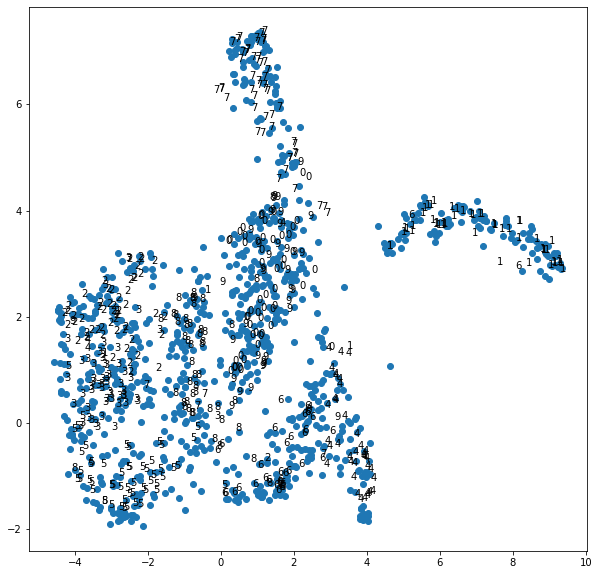

In [ ]:
plot_embeddings(X_train_d[:2000],y_train,X_test_d[:1000])

# SVM

In [ ]:
steps = [('scaler', StandardScaler()), ('SVM', SVC(kernel='poly'))]
pipeline = Pipeline(steps)

parameters = {'SVM__C':[0.001, 0.1, 100, 10e5], 'SVM__gamma':[10,1,0.1,0.01]}
grid = GridSearchCV(pipeline, param_grid=parameters, cv=5)

In [ ]:
grid.fit(X_train, y_train)
print( "score = {}".format((grid.score(X_test, y_test))))
print( "best parameters from train data: ", grid.best_params_)

In [ ]:
test_digits = np.array([ (cv2.resize(img, (28, 28)).reshape(1,-1)).astype(np.float32).reshape(28,28) for img in digits])
test_digits = get_hog(test_digits)
print(test_digits.shape)
predection = grid.predict(test_digits.astype(np.float32))

np.sum(predection.reshape(46) == actual)

In [ ]:
# pipeline.fit(X_train, y_train)
# print( "score = {}".format((pipeline.score(X_test, y_test))))

score = 0.9291440022902949


In [ ]:
# test_digits = np.array([ (cv2.resize(img, (28, 28)).reshape(1,-1)).astype(np.float32).reshape(28,28) for img in digits])
# test_digits = get_hog(test_digits)
# print(test_digits.shape)
# predection = pipeline.predict(test_digits.astype(np.float32))

# np.sum(predection.reshape(46) == actual)

(46, 36)


24

In [ ]:
# #save your model or results
# joblib.dump(grid, 'models/MNIST_SVM.pkl')

In [ ]:
# grid.predict([X_test[0]])

# KNN

In [ ]:
# X_train /= 255
# X_test /= 255

# X_train.shape

(55888, 784)

In [ ]:
X_train.shape

(55888, 38)

In [ ]:
X_train = X_train_d 
X_test = X_test_d 

In [ ]:
knn = cv2.ml.KNearest_create()
knn.train(X_train.astype(np.float32), cv2.ml.ROW_SAMPLE, y_train)

True

In [ ]:
K=13

In [ ]:
ret,y_pred,neighbours,dist = knn.findNearest(X_test.astype(np.float32),k=K)

In [ ]:
len(y_pred)

13972

In [ ]:
np.sum(y_test.reshape(-1,1) == y_pred) / len(y_pred)

0.9103922129974235

In [ ]:
test_digits = np.array([ (cv2.resize(img, (28, 28)).reshape(1,-1)).astype(np.float32).reshape(28,28) for img in digits])
test_digits = preprocess_reshaped(test_digits)#pca.transform()
print(test_digits.shape)

(46, 38)


In [ ]:
predection = knn.findNearest(test_digits.astype(np.float32),k=K)[1]
np.sum(predection.reshape(46) == actual)

26

IndexError: index 46 is out of bounds for axis 0 with size 46

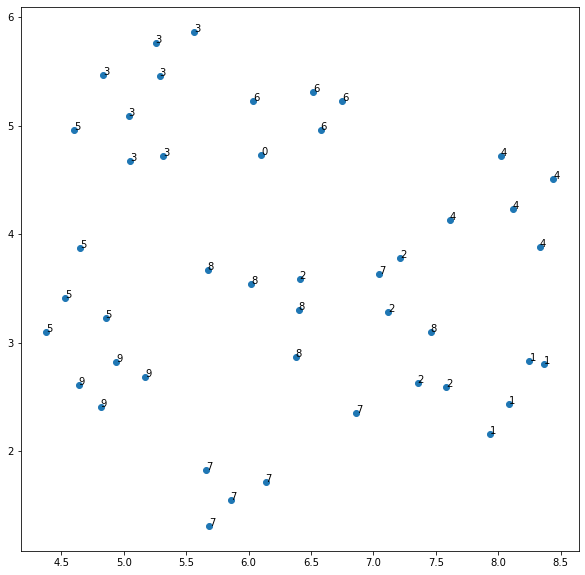

In [ ]:
plot_embeddings(test_digits,actual,test_digits)

# PRE-TRAINED

In [ ]:
model = keras.model.load_model('models/SuperLearner.h5')


Error: Session cannot generate requests